In [60]:
# Enhanced Comparison Analysis - Checkout Visits, Pop-up Modal, and Purchase Events
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns

# Load the CSV file
df = pd.read_csv('analytics.csv')

# Convert created_at to datetime
df['created_at'] = pd.to_datetime(df['created_at'], format='mixed', errors='coerce')
df['date'] = df['created_at'].dt.date

# === 1. ADD-TO-CART EVENTS (from original analysis) ===
add_to_cart_df = df[df['type'] == 'add-to-cart'].copy()
add_to_cart_per_site = add_to_cart_df.groupby('domain').size().reset_index(name='cart_count')
add_to_cart_per_site = add_to_cart_per_site.sort_values('cart_count', ascending=False)
top10_cart_sites = add_to_cart_per_site.head(10).copy()

# === 2. CHECKOUT PAGE VISITS ===
# Filter for URLs containing "/checkout"
checkout_df = df[df['url'].str.contains('/checkout|/cart|/shoppingcart|/bag', case=False, na=False)].copy()
print(f"Total checkout page visits: {len(checkout_df)}")

# Count unique sessions with checkout page visits
checkout_sessions = checkout_df['session_id'].nunique()
print(f"Number of sessions with checkout page visits: {checkout_sessions}")

# Only count one checkout event per session_id per domain
checkout_per_site = checkout_df.drop_duplicates(subset=['domain', 'session_id']).groupby('domain').size().reset_index(name='checkout_count')
checkout_per_site = checkout_per_site.sort_values('checkout_count', ascending=False)
top_checkout_sites = checkout_per_site.head(10)

print("\nTop websites by checkout visits:")
print(top_checkout_sites)

# === 3. ANTI-IMPULSE MODAL DISPLAY ===
# Filter for enforce_wait_modal_shown events
modal_df = df[df['type'] == 'enforce_wait_modal_shown'].copy()
print(f"\nTotal anti-impulse modal displays: {len(modal_df)}")

# Count unique sessions where modal was shown
modal_sessions = modal_df['session_id'].nunique()
print(f"Number of sessions where anti-impulse modal was shown: {modal_sessions}")

# Count modal displays per website
modal_per_site = modal_df.groupby('domain').size().reset_index(name='modal_count')
modal_per_site = modal_per_site.sort_values('modal_count', ascending=False)
top_modal_sites = modal_per_site.head(10)

# Count page-views

page_views_per_site = df[df["type"] == 'page-view'].groupby('domain').size().reset_index(name='page_views')

print("\nTop websites by modal displays:")
print(top_modal_sites)

# === 4. PURCHASE / PLACE-ORDER EVENTS ===
# Filter for place-order events
purchase_df = df[df['type'] == 'place-order'].copy()
print(f"\nTotal purchase/place-order events: {len(purchase_df)}")

# Count unique sessions with purchases
purchase_sessions = purchase_df['session_id'].nunique()
print(f"Number of sessions with completed purchases: {purchase_sessions}")

# Count purchases per website
purchase_per_site = purchase_df.groupby('domain').size().reset_index(name='purchase_count')
purchase_per_site = purchase_per_site.sort_values('purchase_count', ascending=False)
top_purchase_sites = purchase_per_site.head(10)

print("\nTop websites by purchases:")
print(top_purchase_sites)

Total checkout page visits: 524
Number of sessions with checkout page visits: 52

Top websites by checkout visits:
             domain  checkout_count
11    walgreens.com              17
9          shop.app              14
1        amazon.com               4
4    billetlugen.dk               3
10  ticketmaster.dk               3
2         apple.com               2
7            hm.com               2
13         zara.com               2
0      amazon.co.uk               1
3          asos.com               1

Total anti-impulse modal displays: 14
Number of sessions where anti-impulse modal was shown: 10

Top websites by modal displays:
          domain  modal_count
3       shop.app            6
4  walgreens.com            3
2       ikea.com            2
0      apple.com            1
1       etsy.com            1
5       zara.com            1

Total purchase/place-order events: 0
Number of sessions with completed purchases: 0

Top websites by purchases:
Empty DataFrame
Columns: [domain, pu

/var/folders/yv/xt28csc14lq6qntd89nbqmfm0000gn/T/ipykernel_50100/4172160409.py:94: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:.0f}%'.format(x*100) for x in ax.get_xticks()])


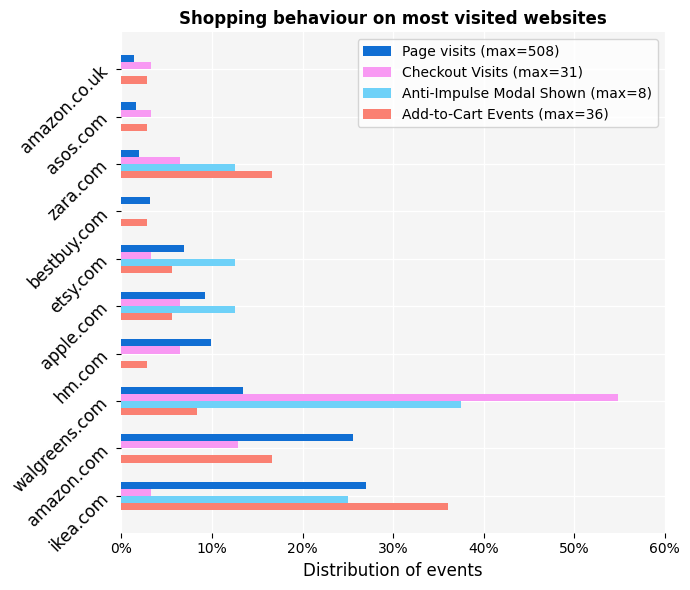

In [70]:
# === 5. TIME SPENT DATA (for comparison) ===
# Filter to include only time-spent events
time_spent_df = df[df['type'] == 'time-spent'].copy()
colors = ['salmon', '#F899F3', '#73FABD', '#6ED1F8','#E0F26D',  '#106ED3']

# Extract duration from payload (convert from milliseconds to minutes)
def extract_duration(payload):
    try:
        data = json.loads(payload)
        duration_ms = data.get('duration', 0)
        return duration_ms / 60000  # Convert ms to minutes
    except (json.JSONDecodeError, TypeError):
        return 0

time_spent_df['duration_minutes'] = time_spent_df['payload'].apply(extract_duration)
website_time_spent = time_spent_df.groupby('domain')['duration_minutes'].sum().reset_index()
website_time_spent = website_time_spent.sort_values('duration_minutes', ascending=False)
top_time_sites = website_time_spent.head(10)

# === 6. COMBINED ANALYSIS ===
# Create a list of all domains that appear in any of our top lists
all_domains = set(list(top10_cart_sites['domain']) + 
                  list(top_checkout_sites['domain']) + 
                  list(top_modal_sites['domain']) + 
                  list(top_purchase_sites['domain']))

# Create a comprehensive dataframe with all metrics
combined_df = pd.DataFrame({'domain': list(all_domains)})

# Merge with each individual metric
combined_df = pd.merge(combined_df, add_to_cart_per_site[['domain', 'cart_count']], on='domain', how='left')
combined_df = pd.merge(combined_df, checkout_per_site[['domain', 'checkout_count']], on='domain', how='left')
combined_df = pd.merge(combined_df, modal_per_site[['domain', 'modal_count']], on='domain', how='left')
combined_df = pd.merge(combined_df, website_time_spent[['domain', 'duration_minutes']], on='domain', how='left')
combined_df = pd.merge(combined_df, page_views_per_site[['domain', 'page_views']], on='domain', how='left')

# Fill NaN values with 0
combined_df = combined_df.fillna(0)

# Sort by cart_count to maintain the same order as the original analysis
combined_df = combined_df.sort_values('page_views', ascending=False)
combined_df = combined_df[~combined_df["domain"].isin(['shop.app', 'ticketmaster.dk', 'billetlugen.dk'])]
combined_df = combined_df.head(10)  # Take top 10 by add-to-cart events

# === 7. CREATE ENHANCED COMPARISON VISUALIZATION ===
plt.figure(figsize=(7, 6))

# Convert seconds to minutes for more intuitive comparison
combined_df['time_spent_minutes'] = combined_df['duration_minutes']

# Normalize the values for visualization (similar to the original comparison)
total_values = {
    'cart_count': combined_df['cart_count'].sum(),
    'checkout_count': combined_df['checkout_count'].sum() if combined_df['checkout_count'].sum() > 0 else 1,
    'modal_count': combined_df['modal_count'].sum() if combined_df['modal_count'].sum() > 0 else 1,
    'time_spent_minutes': combined_df['time_spent_minutes'].sum() if combined_df['time_spent_minutes'].sum() > 0 else 1,
    'page_views': combined_df['page_views'].sum() if combined_df['page_views'].sum() > 0 else 1
}

# Create normalized columns for plotting (normalized by total sum)
for col, total_val in total_values.items():
    combined_df[f'{col}_norm'] = combined_df[col] / total_val

# Set up the plot
domains = combined_df['domain']
y = np.arange(len(domains))
bar_width = 0.15
colors = ['salmon', '#F899F3', '#73FABD', '#6ED1F8','#E0F26D', '#106ED3']

# Plot the bars with different colors
plt.barh(y + bar_width*1.5, combined_df['page_views_norm'], bar_width,
        label=f'Page visits (max={int(total_values["page_views"])})', color=colors[5], zorder=2)

plt.barh(y + bar_width * 0.5, combined_df['checkout_count_norm'], bar_width,
        label=f'Checkout Visits (max={int(total_values["checkout_count"])})', color=colors[1], zorder=2)

plt.barh(y - bar_width*0.5, combined_df['modal_count_norm'], bar_width,
        label=f'Anti-Impulse Modal Shown (max={int(total_values["modal_count"])})', color=colors[3], zorder=2)

plt.barh(y - bar_width*1.5, combined_df['cart_count_norm'], bar_width, 
        label=f'Add-to-Cart Events (max={int(total_values["cart_count"])})', color=colors[0], zorder=2)

ax = plt.gca()
ax.grid(color='white', linewidth=1, axis='y', alpha=1, zorder=1)
ax.grid(color='white', linewidth=1, axis='x', alpha=1, zorder=1)
ax.set_facecolor('#F5F5F5')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.xlabel('Distribution of events', fontsize=12)
ax.set_xlim(0, 0.6)
ax.set_xticklabels(['{:.0f}%'.format(x*100) for x in ax.get_xticks()])
plt.title('Shopping behaviour on most visited websites', fontweight='bold')
plt.yticks(y, domains, rotation=45, ha='right', fontsize=12)
plt.legend(loc='upper right', bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.savefig('shopping-behaviour.png', dpi=300, bbox_inches='tight')
plt.show()

In [36]:
# Show all site-visits on walgreens.com
walgreens_df = df[df['domain'] == 'walgreens.com'].copy()
# Basic counts
print(f"Total site visits on walgreens.com: {len(walgreens_df)}")

# Count unique sessions
walgreens_sessions = walgreens_df['session_id'].nunique()
print(f"Number of unique sessions on walgreens.com: {walgreens_sessions}")

# Identify cart and checkout visits
walgreens_cart_visits = walgreens_df[walgreens_df['url'].str.contains('/cart', case=False, na=False)]
print(f"Cart/checkout visits: {len(walgreens_cart_visits)}")

# Count unique sessions with cart/checkout visits
cart_sessions = walgreens_cart_visits['session_id'].nunique()
print(f"Number of sessions with cart/checkout visits: {cart_sessions}")

# Count anti-impulse modals on walgreens.com
walgreens_modals = walgreens_df[walgreens_df['type'] == 'enforce_wait_modal_shown']
print(f"Anti-impulse modals shown: {len(walgreens_modals)}")

# Analyze user time spent on cart/checkout pages
if 'payload' in walgreens_cart_visits.columns:
    cart_time_spent = walgreens_cart_visits[walgreens_cart_visits['type'] == 'time-spent'].copy()
    
    # Extract duration from payload
    cart_time_spent['duration_minutes'] = cart_time_spent['payload'].apply(extract_duration)
    
    # Calculate total and average time spent
    total_cart_time = cart_time_spent['duration_minutes'].sum()
    avg_cart_time = total_cart_time / len(cart_time_spent) if len(cart_time_spent) > 0 else 0
    
    print(f"\nTime spent analysis on cart/checkout pages:")
    print(f"Total time spent: {total_cart_time:.2f} minutes")
    print(f"Average time per visit: {avg_cart_time:.2f} minutes")


Total site visits on walgreens.com: 374
Number of unique sessions on walgreens.com: 24
Cart/checkout visits: 84
Number of sessions with cart/checkout visits: 17
Anti-impulse modals shown: 3

Time spent analysis on cart/checkout pages:
Total time spent: 4.92 minutes
Average time per visit: 0.08 minutes


In [ ]:

# === 8. CALCULATE CONVERSION METRICS ===
# Calculate conversion rates
combined_df['checkout_rate'] = combined_df.apply(
    lambda row: row['checkout_count'] / row['cart_count'] if row['cart_count'] > 0 else 0, axis=1)
combined_df['purchase_rate'] = combined_df.apply(
    lambda row: row['purchase_count'] / row['checkout_count'] if row['checkout_count'] > 0 else 0, axis=1)
combined_df['cart_to_purchase'] = combined_df.apply(
    lambda row: row['purchase_count'] / row['cart_count'] if row['cart_count'] > 0 else 0, axis=1)
combined_df['modal_effect'] = combined_df.apply(
    lambda row: row['modal_count'] / row['checkout_count'] if row['checkout_count'] > 0 else 0, axis=1)

# Display the conversion metrics
print("\nConversion Metrics by Website:")
conversion_df = combined_df[['domain', 'checkout_rate', 'purchase_rate', 'cart_to_purchase', 'modal_effect']]
conversion_df = conversion_df.round(3)
print(conversion_df.rename(columns={
    'domain': 'Website',
    'checkout_rate': 'Cart → Checkout',
    'purchase_rate': 'Checkout → Purchase',
    'cart_to_purchase': 'Cart → Purchase',
    'modal_effect': 'Modal / Checkout Ratio'
}))

# Create a stacked bar chart showing the funnel from cart to checkout to purchase
plt.figure(figsize=(14, 8))

# Sort by cart_count for better visualization
sorted_df = combined_df.sort_values('cart_count', ascending=True).reset_index(drop=True)

# Create the stacked bars
bars1 = plt.barh(sorted_df['domain'], sorted_df['cart_count'], color='#ff9966', alpha=0.8)
bars2 = plt.barh(sorted_df['domain'], sorted_df['checkout_count'], color='#5ab4ac', alpha=0.8)
bars3 = plt.barh(sorted_df['domain'], sorted_df['purchase_count'], color='#66c2a5', alpha=0.8)

plt.xlabel('Number of Events', fontsize=14)
plt.title('Shopping Conversion Funnel by Website', fontsize=18)
plt.legend([bars1[0], bars2[0], bars3[0]], ['Add to Cart', 'Checkout Visits', 'Purchases'], 
          loc='upper right')
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('shopping_conversion_funnel.png', dpi=300, bbox_inches='tight')
plt.show()

# === 9. MODAL INFLUENCE ANALYSIS ===
# Let's analyze if the modal display affects purchase completion
# For sessions with checkout visits, compare purchase completion rate with and without modal

# Get sessions with checkout visits
checkout_sessions_list = checkout_df['session_id'].unique()

# Filter for sessions where modal was shown
modal_sessions_list = modal_df['session_id'].unique()

# Get sessions with purchases
purchase_sessions_list = purchase_df['session_id'].unique()

# Count conversions
with_modal_sessions = set(checkout_sessions_list).intersection(set(modal_sessions_list))
without_modal_sessions = set(checkout_sessions_list) - set(modal_sessions_list)

# Count purchases in each group
purchases_with_modal = len(set(with_modal_sessions).intersection(set(purchase_sessions_list)))
purchases_without_modal = len(set(without_modal_sessions).intersection(set(purchase_sessions_list)))

# Calculate conversion rates
modal_conversion_rate = purchases_with_modal / len(with_modal_sessions) if len(with_modal_sessions) > 0 else 0
no_modal_conversion_rate = purchases_without_modal / len(without_modal_sessions) if len(without_modal_sessions) > 0 else 0

print("\nModal Influence Analysis:")
print(f"Checkout sessions with modal shown: {len(with_modal_sessions)}")
print(f"Checkout sessions without modal: {len(without_modal_sessions)}")
print(f"Purchase conversion rate with modal: {modal_conversion_rate:.2%}")
print(f"Purchase conversion rate without modal: {no_modal_conversion_rate:.2%}")
print(f"Difference: {(modal_conversion_rate - no_modal_conversion_rate):.2%}")

# Create comparison bar chart
plt.figure(figsize=(10, 6))
conversion_data = [no_modal_conversion_rate * 100, modal_conversion_rate * 100]
labels = ['Without Anti-Impulse Modal', 'With Anti-Impulse Modal']
colors = ['#1f77b4', '#d62728']

bars = plt.bar(labels, conversion_data, color=colors)
plt.title('Purchase Conversion Rate: Effect of Anti-Impulse Modal', fontsize=16)
plt.ylabel('Checkout to Purchase Conversion Rate (%)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Add the values on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{height:.1f}%',
            ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.savefig('modal_influence_analysis.png', dpi=300, bbox_inches='tight')
plt.show()